# Detección automatizada de sargazo mediante Redes Neuronales Convolucionales : Un enfoque de segmentación semántica

### INTEGRANTES DEL EQUIPO:
##### - **Lizette Ariadna Hernández Ortiz**
##### - **Michell Alexis Policarpio Moran**
##### - **Brandon Josafat Mota López**
##### - **Alexis Rivera Merlin**
##### - **Victor Daniel Moreno Luna**
##### - **Isabella Coria Juarez**
# ---
##### *Ubicación: Boca del Rio, Veracruz, México*


In [1]:
# Celda 1: Importaciones, Constantes y Métrica Personalizada

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import cv2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
# import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix
import itertools
import albumentations as A
import requests
import traceback # Para errores detallados

# --- Configuración Inicial ---
IMG_SIZE = (256, 256)
N_CHANNELS = 3
N_CLASSES = 3
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 1e-4

# --- Definición de Colores para Clases ---
CLASS_COLORS = np.array([
    [255, 255, 0],   # Amarillo - Clase 0
    [139, 0, 0],     # Rojo Oscuro - Clase 1 (Sargazo)
    [192, 192, 192], # Gris - Clase 2 (Otros)
], dtype=np.uint8)

# --- Métrica IoU Personalizada ---
class ArgmaxMeanIoU(MeanIoU):
    def __init__(self, num_classes, name=None, dtype=None, **kwargs):
        super(ArgmaxMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, self.dtype)
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.cast(y_pred, self.dtype)
        return super(ArgmaxMeanIoU, self).update_state(y_true, y_pred, sample_weight)

    def get_config(self):
        base_config = super(ArgmaxMeanIoU, self).get_config()
        return base_config

    @classmethod
    def from_config(cls, config):
         return cls(**config)

In [2]:
# Celda 2: Aumentación y Carga de Datos
# --- Definición de Transformaciones de Aumentación (Albumentations) ---
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.4),

    A.GaussNoise(p=0.2),
    A.MotionBlur(blur_limit=5, p=0.2),
    A.CoarseDropout(p=0.3),
], p=1.0)

val_test_transform = A.Compose([])

# --- Función para convertir Máscara RGB a Clases (Índices) ---
def mask_to_classes(mask_rgb):
    mask_rgb = tf.cast(mask_rgb, tf.uint8)
    mask_classes = tf.zeros(tf.shape(mask_rgb)[:2], dtype=tf.int32)
    for i, color in enumerate(CLASS_COLORS):
        class_pixels = tf.reduce_all(mask_rgb == color, axis=-1)
        mask_classes = tf.where(class_pixels, i, mask_classes)
    return mask_classes

# --- Función de Carga y Preprocesamiento ---
def load_image_and_mask(image_path, mask_path, augment):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=N_CHANNELS)
    image = tf.image.resize(image, IMG_SIZE, method='bilinear')
    image = tf.cast(image, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=N_CHANNELS)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask, tf.uint8)

    mask_class = mask_to_classes(mask)

    def _augment_fn(image_np_0_255, mask_class_np):
        image_np = image_np_0_255.numpy()
        mask_class_np = mask_class_np.numpy()
        if augment:
            transformed = train_transform(image=image_np.astype(np.uint8), mask=mask_class_np)
            transformed_image = transformed['image']
            transformed_mask = transformed['mask']
        else:
            transformed_image = image_np.astype(np.uint8)
            transformed_mask = mask_class_np
        transformed_image_normalized = transformed_image.astype(np.float32) / 255.0
        return transformed_image_normalized, transformed_mask.astype(np.int32)

    image_aug, mask_final = tf.py_function(
        _augment_fn,
        [image, mask_class],
        [tf.float32, tf.int32]
    )
    image_aug.set_shape([IMG_SIZE[0], IMG_SIZE[1], N_CHANNELS])
    mask_final.set_shape([IMG_SIZE[0], IMG_SIZE[1]])
    return image_aug, mask_final

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Mounted at /content/drive
Descomprimiendo /content/drive/MyDrive/ProyectoSamsung/dataset.zip en 'dataset'...
Descompresión completa.
Usando ruta de entrenamiento ajustada: 'dataset/dataset/train'
Usando ruta de prueba ajustada: 'dataset/dataset/test'
Imágenes entrenamiento encontradas: 800, Máscaras: 800
Imágenes prueba encontradas: 200, Máscaras: 200
Dataset de entrenamiento creado y configurado.
Dataset de prueba creado y configurado.

Visualizando una muestra...


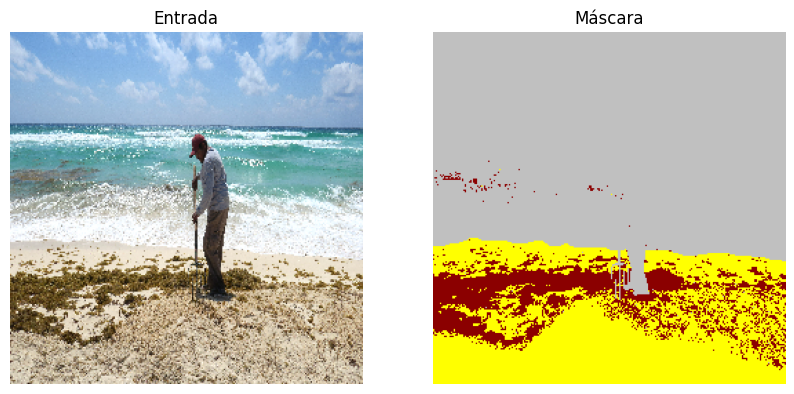

In [3]:
# Celda 3: Preparación del Dataset (Ajustada para estructura anidada)

import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np

# --- Descompresión del Dataset ---
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    dataset_zip_path = '/content/drive/MyDrive/ProyectoSamsung/dataset.zip' # ¡Verifica esta ruta!
except ModuleNotFoundError:
    print("Google Colab no detectado.")
    dataset_zip_path = 'dataset.zip'

dataset_folder = 'dataset' # Carpeta principal donde se extrajo

if not os.path.exists(dataset_folder):
    if os.path.exists(dataset_zip_path):
        print(f"Descomprimiendo {dataset_zip_path} en '{dataset_folder}'...")
        try:
            # Extraer DENTRO de la carpeta 'dataset' para crear dataset/dataset si el zip lo contiene
            with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
                zip_ref.extractall(dataset_folder)
            print("Descompresión completa.")
        except Exception as e: print(f"ERROR descompresión: {e}"); exit()
    else: print(f"ERROR: No se encontró ZIP ni carpeta dataset."); exit()
else: print(f"La carpeta '{dataset_folder}' ya existe (o ya fue creada).")

# --- Rutas y Listado de Archivos ---
# *** AJUSTE REALIZADO AQUÍ para la estructura anidada detectada ***
# Apuntar a dataset/dataset/train y dataset/dataset/test
train_dir = os.path.join(dataset_folder, dataset_folder, 'train')
test_dir = os.path.join(dataset_folder, dataset_folder, 'test')

print(f"Usando ruta de entrenamiento ajustada: '{train_dir}'")
print(f"Usando ruta de prueba ajustada: '{test_dir}'")

def get_paths(data_dir):
    # dentro de train/test los nombres son 'source' y 'target'
    source_folder_name = 'source'
    target_folder_name = 'target'
    img_dir = os.path.join(data_dir, source_folder_name)
    mask_dir = os.path.join(data_dir, target_folder_name)

    # Verificar si las rutas ajustadas existen ahora
    if not os.path.isdir(img_dir) or not os.path.isdir(mask_dir):
        print(f"ERROR CRÍTICO: Incluso con la ruta ajustada, no se encuentran '{source_folder_name}' o '{target_folder_name}' en '{data_dir}'")
        print("Verifica manualmente la estructura exacta con el explorador de archivos.")
        return [], []
    try:
        images = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        if len(images) != len(masks): print(f"ADVERTENCIA: Num imágenes != num máscaras en {data_dir}."); return [], []
        base_images = [os.path.splitext(os.path.basename(p))[0] for p in images]
        base_masks = [os.path.splitext(os.path.basename(p))[0] for p in masks]
        if base_images != base_masks: print(f"ADVERTENCIA: Nombres base no coinciden en {data_dir}.")
        return images, masks
    except Exception as e: print(f"Error listando archivos en {data_dir}: {e}"); return [], []

train_images, train_masks = get_paths(train_dir)
test_images, test_masks = get_paths(test_dir)

print(f"Imágenes entrenamiento encontradas: {len(train_images)}, Máscaras: {len(train_masks)}")
print(f"Imágenes prueba encontradas: {len(test_images)}, Máscaras: {len(test_masks)}")

# --- Crear tf.data.Datasets ---
def create_tf_dataset(image_paths, mask_paths, augment):
    if not image_paths or not mask_paths or len(image_paths) != len(mask_paths):
        print("Error creando dataset: Listas vacías o no coincidentes."); return None
    try:
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
        dataset = dataset.map(lambda img, mask: load_image_and_mask(img, mask, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)
        return dataset
    except NameError: print("ERROR: 'load_image_and_mask' no definida (ejecuta Celda 2)."); return None
    except Exception as e: print(f"Error creando tf.data.Dataset: {e}"); return None

train_dataset = create_tf_dataset(train_images, train_masks, augment=True)
test_dataset = create_tf_dataset(test_images, test_masks, augment=False)

# --- Configurar Datasets ---
if train_dataset:
    # Usar BATCH_SIZE definido en Celda 1
    buffer_size = min(len(train_images), 1000)
    train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print("Dataset de entrenamiento creado y configurado.")
if test_dataset:
    # Usar BATCH_SIZE definido en Celda 1
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print("Dataset de prueba creado y configurado.")

# --- Visualizar una Muestra (Opcional) ---
# (Solo si los datasets se crearon correctamente)
if train_dataset:
    print("\nVisualizando una muestra...")
    try:
        plt.figure(figsize=(10, 5))
        # Usar IMG_SIZE, N_CHANNELS, CLASS_COLORS definidos en Celda 1
        for i, (img, mask) in enumerate(train_dataset.take(1)):
            plt.subplot(1, 2, 1); plt.imshow(img[0]); plt.title("Entrada"); plt.axis('off')
            plt.subplot(1, 2, 2)
            mask_rgb_display = np.zeros((IMG_SIZE[0], IMG_SIZE[1], N_CHANNELS), dtype=np.uint8)
            for class_idx, color in enumerate(CLASS_COLORS):
                 if class_idx < N_CLASSES: mask_rgb_display[mask[0].numpy() == class_idx] = color
            plt.imshow(mask_rgb_display); plt.title("Máscara"); plt.axis('off')
            break
        plt.show()
    except Exception as e: print(f"Error visualizando muestra: {e}.")
elif train_images and train_masks: print("train_dataset no se pudo crear.")
else: print("No hay datos válidos para crear los datasets.")

In [21]:
# Celda 4: Definición del Modelo U-Net
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# --- Bloque Convolucional ---
def conv_block(input_tensor, num_filters, kernel_size=(3, 3), batch_norm=True, dropout_rate=0.0):
    x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(input_tensor)
    if batch_norm: x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    if batch_norm: x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout_rate > 0.0: x = Dropout(dropout_rate)(x)
    return x

# --- Arquitectura U-Net v2 ---
def unet_model_v2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], N_CHANNELS), num_classes=N_CLASSES, dropout_rate=0.15, batch_norm=True):
    # (Asegúrate que IMG_SIZE, N_CHANNELS, N_CLASSES estén definidas en Celda 1)
    inputs = Input(shape=input_shape)
    c1 = conv_block(inputs, 32, batch_norm=batch_norm); p1 = MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 64, batch_norm=batch_norm); p2 = MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 128, batch_norm=batch_norm); p3 = MaxPooling2D((2, 2))(c3)
    c4 = conv_block(p3, 256, batch_norm=batch_norm); p4 = MaxPooling2D((2, 2))(c4)
    c5 = conv_block(p4, 512, batch_norm=batch_norm, dropout_rate=dropout_rate)
    u6 = UpSampling2D((2, 2))(c5); u6 = concatenate([u6, c4]); c6 = conv_block(u6, 256, batch_norm=batch_norm)
    u7 = UpSampling2D((2, 2))(c6); u7 = concatenate([u7, c3]); c7 = conv_block(u7, 128, batch_norm=batch_norm)
    u8 = UpSampling2D((2, 2))(c7); u8 = concatenate([u8, c2]); c8 = conv_block(u8, 64, batch_norm=batch_norm)
    u9 = UpSampling2D((2, 2))(c8); u9 = concatenate([u9, c1]); c9 = conv_block(u9, 32, batch_norm=batch_norm)
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=inputs, outputs=outputs)

    # (Asegúrate que LEARNING_RATE esté definida en Celda 1)
    optimizer = Adam(learning_rate=LEARNING_RATE)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # (Asegúrate que ArgmaxMeanIoU esté definida en Celda 1)
    metrics = ['accuracy', ArgmaxMeanIoU(num_classes=num_classes, name='iou')]
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

# --- Crear y Mostrar Resumen ---
model = None # Limpiar posible modelo anterior
try:
    model = unet_model_v2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], N_CHANNELS), num_classes=N_CLASSES, dropout_rate=0.15)
    model.summary()
except NameError as e: print(f"ERROR: Falta definición (probablemente de Celda 1): {e}")
except Exception as e: print(f"Error creando modelo: {e}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 256, 256, 32)   │            128 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 256, 256, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 256, 256, 32)   │            128 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 256, 256, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 32)   │              0 │ activation_19[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 128, 128, 64)   │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 128, 128, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 128, 128, 64)   │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 128, 128, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5      

 Total params: 7,858,499 (29.98 MB)

 Trainable params: 7,852,611 (29.96 MB)

 Non-trainable params: 5,888 (23.00 KB)


--- Iniciando Entrenamiento ---
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5978 - iou: 0.4093 - loss: 0.9158
Epoch 1: val_loss improved from inf to 0.80460, saving model to best_sargassum_model_v2.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 248ms/step - accuracy: 0.5986 - iou: 0.4101 - loss: 0.9144 - val_accuracy: 0.6686 - val_iou: 0.4546 - val_loss: 0.8046 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7566 - iou: 0.5995 - loss: 0.6198
Epoch 2: val_loss improved from 0.80460 to 0.55535, saving model to best_sargassum_model_v2.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 0.7566 - iou: 0.5995 - loss: 0.6198 - val_accuracy: 0.7994 - val_iou: 0.6556 - val_loss: 0.5554 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7783 - iou: 0.6285 - loss: 0.5667
Epoch 3: val_loss improved from 0.55535 to 0.46872, saving model to best_sargassum_model_v2.keras
100/100 ━━━

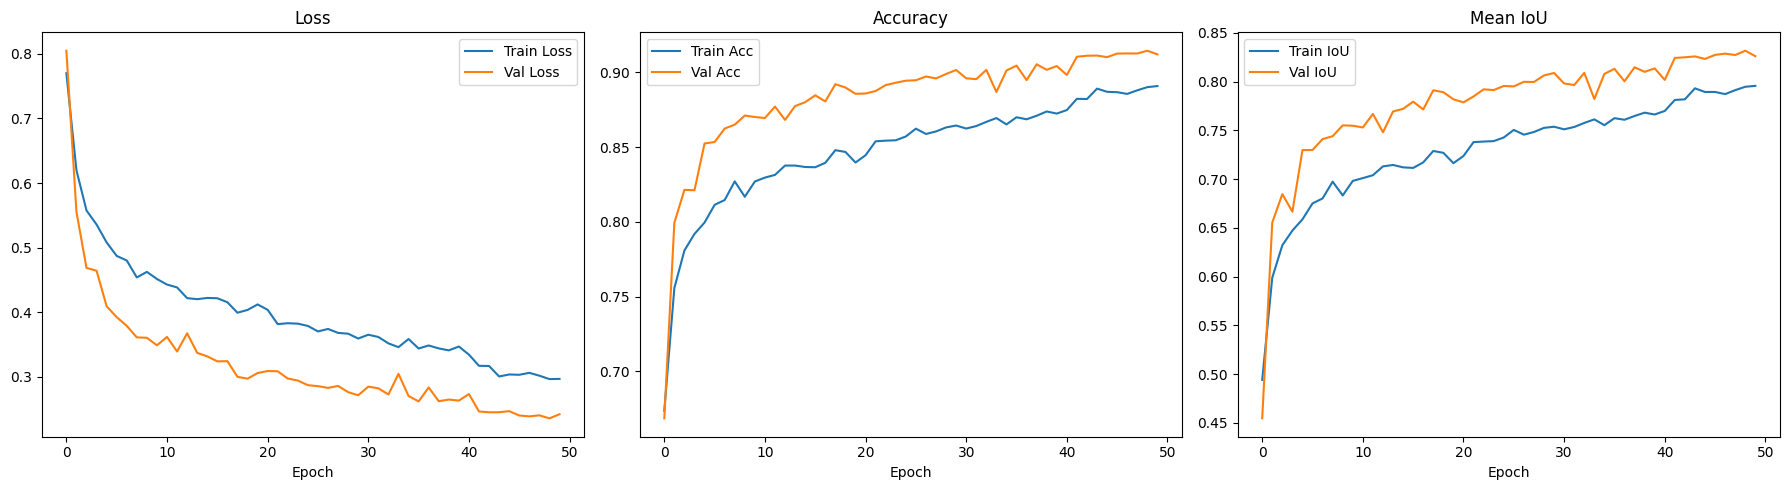

In [5]:
# Celda 5: Entrenamiento del Modelo

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import traceback

# --- Callbacks ---
checkpoint = ModelCheckpoint('best_sargassum_model_v2.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, mode='min', verbose=1)
callbacks_list = [checkpoint, early_stopping, reduce_lr]

# --- Configuración Entrenamiento ---
# Usa los datasets creados en la Celda 3 ajustada
validation_data = test_dataset if 'test_dataset' in locals() and test_dataset is not None else None
steps_per_epoch = None; validation_steps = None
# Usa las listas de imágenes/máscaras obtenidas en Celda 3 ajustada
if 'train_images' in locals() and train_images and BATCH_SIZE > 0: steps_per_epoch = len(train_images) // BATCH_SIZE
if validation_data and 'test_images' in locals() and test_images and BATCH_SIZE > 0: validation_steps = len(test_images) // BATCH_SIZE

# --- Ejecutar Entrenamiento ---
history = None
# Aqui solo se verifica que el modelo (Celda 4) y los datasets (Celda 3) existan
if model is not None and 'train_dataset' in locals() and train_dataset is not None and validation_data is not None:
    print("\n--- Iniciando Entrenamiento ---")
    try:
        history = model.fit(
            train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
            validation_data=validation_data, validation_steps=validation_steps,
            callbacks=callbacks_list
        )
        print("\n--- Entrenamiento Finalizado ---")
        # --- Graficar Curvas ---
        if history and history.history:
             print("\nGraficando historial...")
             plt.figure(figsize=(18, 5))
             plt.subplot(1, 3, 1); plt.plot(history.history['loss'], label='Train Loss'); plt.plot(history.history['val_loss'], label='Val Loss'); plt.title('Loss'); plt.legend(); plt.xlabel('Epoch')
             plt.subplot(1, 3, 2); plt.plot(history.history['accuracy'], label='Train Acc'); plt.plot(history.history['val_accuracy'], label='Val Acc'); plt.title('Accuracy'); plt.legend(); plt.xlabel('Epoch')
             if 'iou' in history.history and 'val_iou' in history.history:
                 plt.subplot(1, 3, 3); plt.plot(history.history['iou'], label='Train IoU'); plt.plot(history.history['val_iou'], label='Val IoU'); plt.title('Mean IoU'); plt.legend(); plt.xlabel('Epoch')
             plt.tight_layout(); plt.show()
        else: print("No se generó historial.")
    except Exception as e: print(f"Error entrenamiento: {e}"); print(traceback.format_exc())
else:
    print("No se puede entrenar. Faltan componentes:")
    if model is None: print("- Modelo no definido/creado (Celda 4).")
    if 'train_dataset' not in locals() or train_dataset is None: print("- Dataset de entrenamiento no disponible (Celda 3).")
    if validation_data is None: print("- Dataset de validación no disponible (Celda 3).")

Cargando modelo: best_sargassum_model_v2.keras
Modelo cargado.

Evaluando modelo en Test...
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.9121 - iou: 0.8188 - loss: 0.2426

Métricas en Test: {'accuracy': 0.9145103693008423, 'iou': 0.8318149447441101, 'loss': 0.2360372096300125}

Calculando Matriz Confusión...
Matriz Normalizada


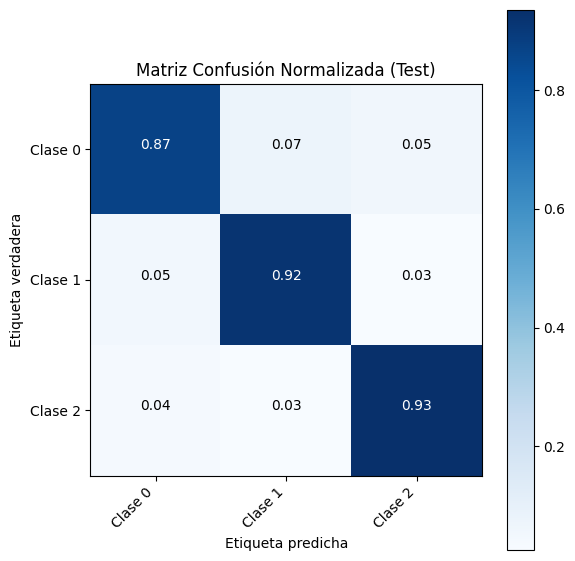

In [7]:
# # Celda 6: Evaluación Cuantitativa y Matriz de Confusión
# %%
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import traceback

# --- Función Graficar Matriz Confusión ---
def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de Confusión', cmap=plt.cm.Blues):
    if normalize:
        cm_sum = cm.sum(axis=1, keepdims=True)
        cm_normalized = np.divide(cm.astype('float'), cm_sum, out=np.zeros_like(cm, dtype=float), where=cm_sum!=0)
        cm = cm_normalized; print("Matriz Normalizada")
    else: print("Matriz sin normalizar")
    figsize = max(6, len(classes) * 0.8); plt.figure(figsize=(figsize, figsize)); plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title); plt.colorbar(); tick_marks = np.arange(len(classes)); plt.xticks(tick_marks, classes, rotation=45, ha="right"); plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'; thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        value = cm[i, j]; cell_text = "NaN" if np.isnan(value) else format(value, fmt)
        plt.text(j, i, cell_text, horizontalalignment="center", color="white" if value > thresh else "black")
    plt.ylabel('Etiqueta verdadera'); plt.xlabel('Etiqueta predicha'); plt.tight_layout(); plt.show()

# --- Carga y Evaluación ---
best_model_path = 'best_sargassum_model_v2.keras' # Archivo guardado en Celda 5
best_model = None
if os.path.exists(best_model_path):
    print(f"Cargando modelo: {best_model_path}")
    try:
        # Asegurar que ArgmaxMeanIoU (Celda 1) esté definida
        best_model = tf.keras.models.load_model(best_model_path, custom_objects={'ArgmaxMeanIoU': ArgmaxMeanIoU})
        print("Modelo cargado.")
    except Exception as e: print(f"Error al cargar modelo: {e}"); print(traceback.format_exc())
else: print(f"Error: No se encontró {best_model_path}.")

# Usa test_dataset de Celda 3
if best_model and 'test_dataset' in locals() and test_dataset is not None:
    print("\nEvaluando modelo en Test..."); # --- Evaluación ---
    try:
        results = best_model.evaluate(test_dataset, return_dict=True)
        print(f"\nMétricas en Test: {results}")
    except Exception as e: print(f"Error evaluación: {e}")
    print("\nCalculando Matriz Confusión..."); # --- Matriz Confusión ---
    y_true = []; y_pred = []
    try:
        for images, masks_true in test_dataset:
            predictions = best_model(images, training=False)
            predicted_labels = tf.argmax(predictions, axis=-1).numpy()
            y_true.extend(masks_true.numpy().flatten()); y_pred.extend(predicted_labels.flatten())
        y_true = np.array(y_true, dtype=int); y_pred = np.array(y_pred, dtype=int)
        present_labels = np.unique(np.concatenate((y_true, y_pred)))
        cm = confusion_matrix(y_true, y_pred, labels=present_labels)
        # Usa N_CLASSES de Celda 1
        class_names_all = [f'Clase {i}' for i in range(N_CLASSES)]; present_class_names = [class_names_all[i] for i in present_labels if i < len(class_names_all)]
        plot_confusion_matrix(cm, classes=present_class_names, normalize=True, title='Matriz Confusión Normalizada (Test)')
    except Exception as e: print(f"Error matriz confusión: {e}"); print(traceback.format_exc())
elif not best_model: print("Modelo no cargado.")
else: print("Dataset de prueba no disponible (Celda 3).")


Mostrando 3 ejemplos...


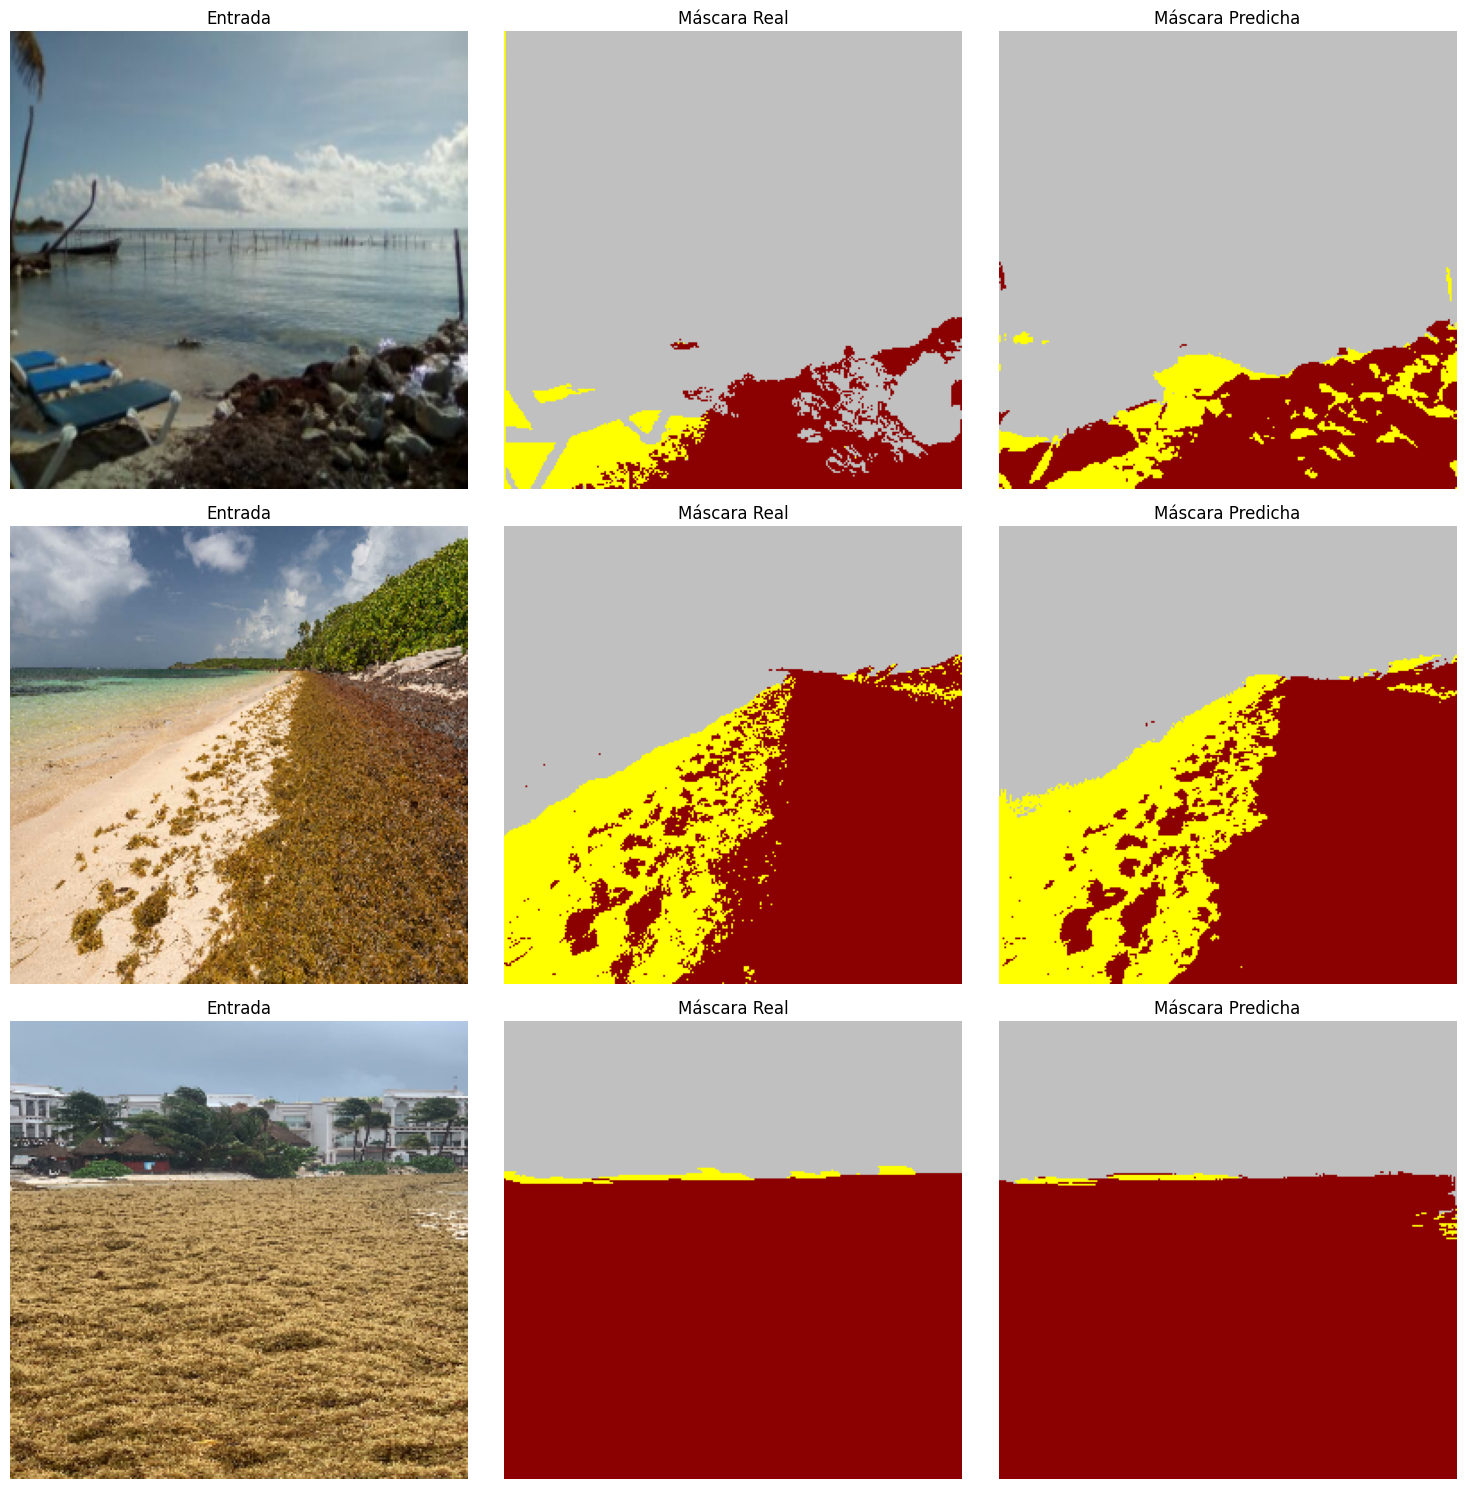

In [9]:
# Celda 7: Visualización Cualitativa de Muestras

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import traceback

# --- Función Graficar Predicciones ---
def plot_predictions(dataset, model, num_samples=3):
    if dataset is None: print("Dataset no disponible."); return
    if model is None: print("Modelo no disponible."); return
    # Usa CLASS_COLORS y N_CLASSES de Celda 1
    if 'CLASS_COLORS' not in globals() or 'N_CLASSES' not in globals(): print("Error: CLASS_COLORS/N_CLASSES no definidos."); return
    print(f"\nMostrando {num_samples} ejemplos...");
    try:
        images, true_masks = next(iter(dataset.take(1))); preds_probs = model(images, training=False)
        preds_masks = tf.argmax(preds_probs, axis=-1).numpy(); num_samples = min(num_samples, images.shape[0])
        plt.figure(figsize=(15, num_samples * 5))
        for i in range(num_samples):
            plt.subplot(num_samples, 3, i * 3 + 1); plt.imshow(images[i]); plt.title("Entrada"); plt.axis('off')
            true_mask_rgb = np.zeros_like(images[i].numpy(), dtype=np.float32)
            for class_idx, color in enumerate(CLASS_COLORS):
                 if class_idx < N_CLASSES: true_mask_rgb[true_masks[i].numpy() == class_idx] = color / 255.0
            plt.subplot(num_samples, 3, i * 3 + 2); plt.imshow(true_mask_rgb); plt.title("Máscara Real"); plt.axis('off')
            pred_mask_rgb = np.zeros_like(images[i].numpy(), dtype=np.float32)
            for class_idx, color in enumerate(CLASS_COLORS):
                 if class_idx < N_CLASSES: pred_mask_rgb[preds_masks[i] == class_idx] = color / 255.0
            plt.subplot(num_samples, 3, i * 3 + 3); plt.imshow(pred_mask_rgb); plt.title("Máscara Predicha"); plt.axis('off')
        plt.tight_layout(); plt.show()
    except StopIteration: print("Error: Dataset vacío.")
    except Exception as e: print(f"Error visualización: {e}"); print(traceback.format_exc())

# --- Ejecutar Visualización ---
# Usa best_model (Celda 6.1) y test_dataset (Celda 3)
if 'best_model' in locals() and best_model is not None and 'test_dataset' in locals() and test_dataset is not None:
    plot_predictions(test_dataset, best_model, num_samples=3)
else:
    print("No se puede ejecutar visualización.")
    if 'best_model' not in locals() or best_model is None: print("- Modelo no disponible (Celda 6.1).")
    if 'test_dataset' not in locals() or test_dataset is None: print("- Dataset prueba no disponible (Celda 3).")


Probando detección en imagen individual...


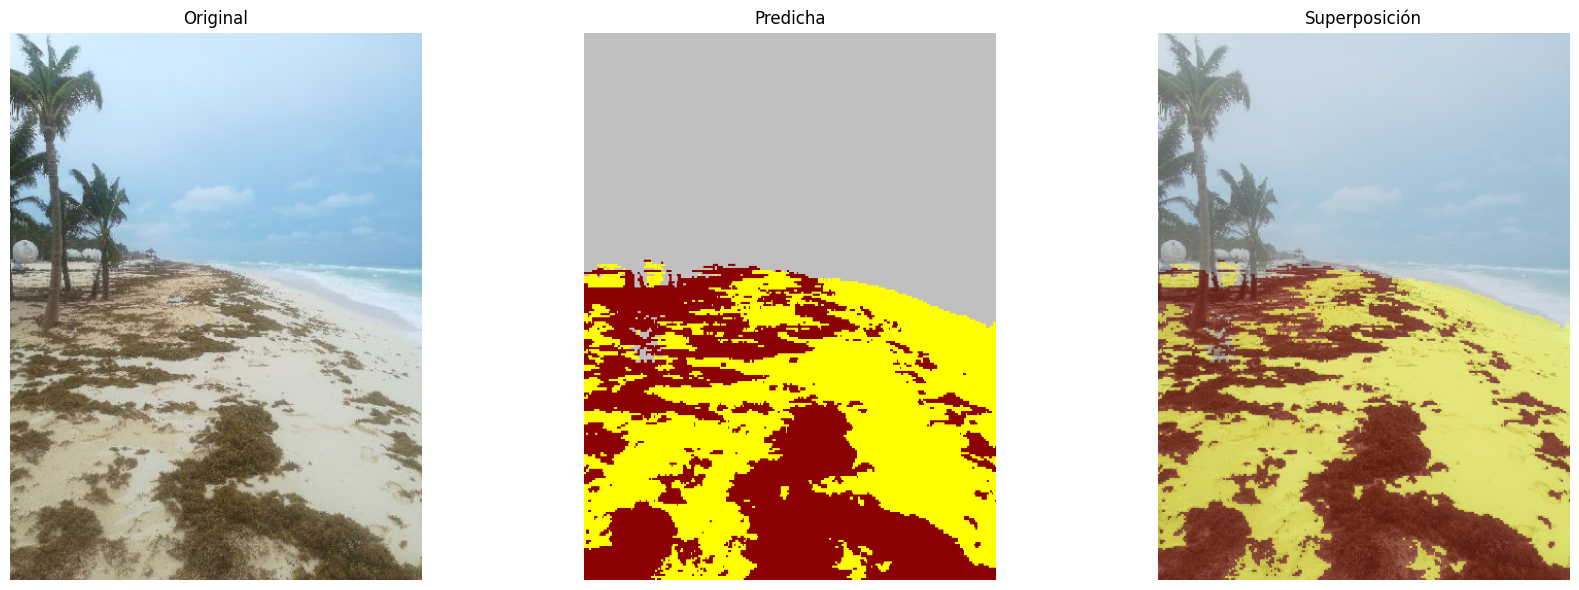


Distribución Clases (Porcentaje Total Imagen):
- Clase 0: 29.33%
- Clase 1: 24.65%
- Clase 2: 46.01%

--- Nivel de Recale de Sargazo ---
(Calculado usando Clase 1 como Sargazo y Clase 0 como Arena)
Porcentaje Relativo de Sargazo (Clase 1 / (Clase 1 + Clase 0)): 45.66%
Clasificación Estimada: Moderado


In [22]:
# Celda 8: Detección en Imagen Individual (Categorización según Tabla)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import traceback

# --- Función Detectar Sargazo v2 (Categorización) ---
def detect_sargassum_v2(image_path, model, img_size, class_colors):
    # --- Validaciones Robustas ---
    num_defined_classes = len(class_colors) if isinstance(class_colors, (list, np.ndarray)) else 0
    try:
      model_output_classes = getattr(model, 'output_shape', [None, None, None, 0])[-1]
      if model_output_classes is None: model_output_classes = num_defined_classes
    except: model_output_classes = num_defined_classes
    if not isinstance(image_path, str) or not os.path.exists(image_path): print(f"Error: Ruta inválida: '{image_path}'"); return None, None, "Error"
    if model is None or not isinstance(model, tf.keras.Model): print("Error: Modelo inválido."); return None, None, "Error"
    if not hasattr(img_size, '__len__') or len(img_size)!= 2 or not all(isinstance(d, int) and d > 0 for d in img_size): print(f"Error: img_size '{img_size}' inválido."); return None, None, "Error"
    if num_defined_classes == 0: print("Error: class_colors inválido."); return None, None, "Error"
    if num_defined_classes != model_output_classes: print(f"ADVERTENCIA: Num colores ({num_defined_classes}) != clases modelo ({model_output_classes}).")

    try:
        # --- Carga y Preprocesamiento ---
        image = cv2.imread(image_path);
        if image is None: print(f"Error al leer imagen: '{image_path}'"); return None, None, "Error"
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB); original_shape = image_rgb.shape[:2]
        image_resized = cv2.resize(image_rgb, tuple(img_size), interpolation=cv2.INTER_LINEAR)
        image_normalized = image_resized.astype(np.float32) / 255.0
        image_input = np.expand_dims(image_normalized, axis=0)

        # --- Predicción ---
        prediction_probs = model(image_input, training=False)
        if len(prediction_probs.shape)!= 4: print(f"Error: Forma salida inesperada: {prediction_probs.shape}"); return None, None, "Error"
        pred_mask_indices = np.argmax(prediction_probs[0], axis=-1)
        pred_mask_resized_indices = cv2.resize(pred_mask_indices.astype(np.uint8), (original_shape[1], original_shape[0]), interpolation=cv2.INTER_NEAREST)

        # --- Visualización ---
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1); plt.imshow(image_rgb); plt.title('Original'); plt.axis('off')
        pred_mask_rgb = np.zeros((original_shape[0], original_shape[1], 3), dtype=np.uint8)
        for i, color in enumerate(class_colors): pred_mask_rgb[pred_mask_resized_indices == i] = color
        plt.subplot(1, 3, 2); plt.imshow(pred_mask_rgb); plt.title('Predicha'); plt.axis('off')
        overlay = image_rgb.copy(); alpha = 0.4
        for i, color in enumerate(class_colors):
            mask_pixels = pred_mask_resized_indices == i
            if np.any(mask_pixels):
                original_pixels = overlay[mask_pixels]; class_color_np = np.array(color, dtype=np.uint8)
                blended_pixels = (original_pixels.astype(np.float32) * (1 - alpha) + class_color_np.astype(np.float32) * alpha)
                overlay[mask_pixels] = blended_pixels.clip(0, 255).astype(np.uint8)
        plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title('Superposición'); plt.axis('off')
        plt.tight_layout(); plt.show()

        # --- Cálculo de Porcentajes Totales ---
        total_pixels = pred_mask_resized_indices.size
        unique, counts = np.unique(pred_mask_resized_indices, return_counts=True);
        class_distribution = {cls: (count / total_pixels * 100) for cls, count in zip(unique, counts)}
        print("\nDistribución Clases (Porcentaje Total Imagen):");
        for cls_idx in range(num_defined_classes): print(f"- Clase {cls_idx}: {class_distribution.get(cls_idx, 0.0):.2f}%")

        # --- Categorización del Nivel de Sargazo ---
        print("\n--- Nivel de Recale de Sargazo ---")
        # Asunciones: 0=Arena(Amarillo), 1=Sargazo(RojoOscuro), 2=Otros (cielo, etc)
        print(f"(Calculado usando Clase 1 como Sargazo y Clase 0 como Arena)")

        # Obtener porcentajes usando índices directamente
        sargazo_perc_total = class_distribution.get(1, 0.0)    # Clase 1 = Sargazo
        arena_perc_total = class_distribution.get(0, 0.0)      # Clase 0 = Arena

        # Calcular el total relevante (Sargazo [1] + Arena [0])
        total_relevante_perc_total = sargazo_perc_total + arena_perc_total

        relative_sargazo_perc = 0.0
        nivel = "Indeterminado"

        if total_relevante_perc_total > 0.01: # Umbral mínimo
            relative_sargazo_perc = (sargazo_perc_total / total_relevante_perc_total) * 100
            print(f"Porcentaje Relativo de Sargazo (Clase 1 / (Clase 1 + Clase 0)): {relative_sargazo_perc:.2f}%")

            # --- UMBRALES Y ETIQUETAS AJUSTADOS A LA IMAGEN ---
            if relative_sargazo_perc < 20:      # 0% a 19.99%
                nivel = "Bajo"
            elif relative_sargazo_perc < 50:    # 20% a 49.99%
                nivel = "Moderado"
            elif relative_sargazo_perc < 80:    # 50% a 79.99%
                nivel = "Alto"
            else:                               # 80% a 100%
                nivel = "Crítico"
            # --- FIN DE AJUSTE ---

        else:
            print(f"No se detectó suficiente área relevante (Clase 1 + Clase 0 < 0.01%) para calcular nivel.")
            # Casos especiales (ajustados a las nuevas etiquetas)
            if sargazo_perc_total > 0.01 and arena_perc_total < 0.01:
                 # Si solo hay sargazo, es crítico
                 nivel = "Crítico (Solo sargazo detectado)"
            elif arena_perc_total > 0.01 and sargazo_perc_total < 0.01:
                 # Si solo hay arena, es bajo
                 nivel = "Bajo (Solo arena detectada)"

        print(f"Clasificación Estimada: {nivel}")
        # ----------------------------------------------------------------------

        return overlay, class_distribution, nivel

    except Exception as e:
        print(f"Error Crítico en detect_sargassum_v2: {e}")
        print(traceback.format_exc())
        return None, None, "Error"

# --- Ejecutar Detección ---
if ('best_model' in locals() and best_model is not None and
    'IMG_SIZE' in locals() and 'CLASS_COLORS' in locals()):
    print("\nProbando detección en imagen individual...")
    image_to_test = 'image_1.jpg' # <--- Nombre de la imagen a probar aquiiiii
    if os.path.exists(image_to_test):
        resultado_overlay, dist_clases, nivel_recale = detect_sargassum_v2(
            image_to_test, best_model, img_size=IMG_SIZE, class_colors=CLASS_COLORS
        )
    else: print(f"ADVERTENCIA: No se encontró '{image_to_test}'.")
else:
    print("\nNo se puede ejecutar detección. Faltan componentes.")
    # ... (mensajes de error) ...